In [1]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla K80


In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import re
from tqdm import tqdm_notebook

from nltk.corpus import stopwords

from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [3]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 100 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 100
GLOVE_DIR = r"glove.twitter.27B.100d.txt"

In [4]:
import os 
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/DATASET AML/')

Mounted at /content/drive


# Import Glove

In [5]:
embeddings_index = {}
f = open(GLOVE_DIR, encoding="utf8")
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")


Loading GloVe from: glove.twitter.27B.100d.txt ...Done.
 Proceeding with Embedding Matrix...

Mounted at /content/drive


#Import Dataset

EDA BINARY

In [6]:
os.chdir('/content/drive/My Drive/DATASET AML/PROJECT/dataset_giusti')

In [7]:
train = pd.read_csv("BINARY_augmented_Trans_undersampling_senza_stopword_FINAL.csv")
train["comment_text"] = train["comment_text"].astype(str)
train.head()

,comment_text,bad
0,reply gender post not guess someone gender unc...,1
1,reference review delete try keep variety diffe...,0
2,reference hi not confuse wpcite current state ...,0
3,block cannot respond lie,1
4,fuck fite edit page youre top class tallywacke...,1


#Tokenization and Embedding

In [8]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(train['comment_text'].values)
sequences = tokenizer.texts_to_sequences(train["comment_text"])
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 67071


In [9]:
embeddings_dict = {}

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_dict[word] = embedding_vector
print(" Completed!")

 Completed!


In [10]:
tsne = TSNE(n_components=2, random_state=0)
words =  list(embeddings_dict.keys())
vectors = [embeddings_dict[word] for word in words]

In [11]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

In [12]:
labels = ['bad']
y = to_categorical(train[labels].values)

In [13]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (39388, 100)
Shape of label tensor: (39388, 2)


In [14]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]

In [15]:
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [15762. 15749.]
validation:  [3929. 3948.]


In [16]:
print('Tokenized sentences: \n', data[20])
print('One hot label: \n', labels[20])

Tokenized sentences: 
 [   46    66    40   224    46   776 53680  2220  2515 13853 27799  1974
    67   490 53681     6    58   500    46   812    13    66     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
One hot label: 
 [1. 0.]


In [17]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

 Completed!


#LSTM MODEL

In [18]:
from tensorflow.keras.layers import Bidirectional
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)
import keras

In [22]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)
x = (Bidirectional(LSTM(60, return_sequences=True,name='lstm_layer')))(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(2, activation="softmax")(x)

In [23]:
model = Model(sequence_input, preds)
model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics = [tf.keras.metrics.Recall()])

In [24]:
print('Training progress:')
history = model.fit(x_train, y_train, epochs = 4, batch_size=128, validation_data=(x_val, y_val), verbose = 2, callbacks=[callback])

Training progress:
Epoch 1/4
247/247 - 13s - loss: 0.3134 - recall_1: 0.8655 - val_loss: 0.2270 - val_recall_1: 0.9081
Epoch 2/4
247/247 - 9s - loss: 0.2185 - recall_1: 0.9100 - val_loss: 0.2178 - val_recall_1: 0.9109
Epoch 3/4
247/247 - 9s - loss: 0.2016 - recall_1: 0.9183 - val_loss: 0.2082 - val_recall_1: 0.9144
Epoch 4/4
247/247 - 9s - loss: 0.1911 - recall_1: 0.9216 - val_loss: 0.2039 - val_recall_1: 0.9152


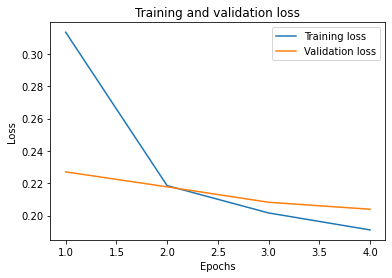

In [25]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

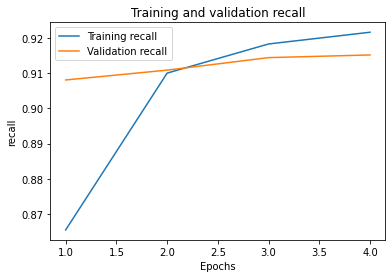

In [27]:
accuracy = history.history['recall_1']
val_accuracy = history.history['val_recall_1']
plt.plot(epochs, accuracy, label='Training recall')
plt.plot(epochs, val_accuracy, label='Validation recall')
plt.title('Training and validation recall')
plt.ylabel('recall')
plt.xlabel('Epochs')
plt.legend()
plt.show();

# Test

In [28]:
os.chdir('/content/drive/My Drive/DATASET AML/PROJECT/dataset_giusti/TEST')

In [29]:
test = pd.read_csv("test_binary_senza_stopword.csv")

In [30]:
test

,Unnamed: 0,Unnamed: 0.1,comment_text,bad
0,0,5,thank you for understand i think very highly o...,0
1,1,7,dear god this site be horrible,0
2,2,11,somebody will invariably try to add religion r...,0
3,3,13,it say it right there that it be a type the ty...,0
4,4,14,before add a new product to the list make sure...,0
...,...,...,...,...
63973,63973,153150,jerome i see you never get around to this im n...,0
63974,63974,153151,lucky bastard httpwikimediafoundationorgwikipr...,0
63975,63975,153154,shame on you all you want to speak about gay a...,0
63976,63976,153155,mel gibson be a nazi bitch who make shitty mov...,1


In [31]:

sequences = tokenizer.texts_to_sequences(test["comment_text"].astype(str))


In [32]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

In [33]:
labels = ['bad']
y = to_categorical(test[labels].values)

In [34]:
eval= model.evaluate(data,y)

2000/2000 [==============================] - 34s 17ms/step - loss: 0.4296 - recall_1: 0.8383


In [35]:
performance = model.predict(data)


In [40]:
import sklearn
y_pred =np.round(performance)
print("RECALL: ", sklearn.metrics.recall_score(y, y_pred, average= 'weighted'))
print("PRECISION: ",sklearn.metrics.precision_score(y, y_pred, average= 'weighted'))
print("F1-SCORE: ",sklearn.metrics.f1_score(y, y_pred, average= 'weighted'))



mat =sklearn.metrics.multilabel_confusion_matrix(y,y_pred)
accuracy=[]
for i in range(mat.shape[0]):

  accuracy.append((mat[i][1][1]+mat[i][0][0])/(mat[i][1][1]+mat[i][0][0]+mat[i][0][1]+mat[i][1][0]))

def Average(lst): 
    return sum(lst) / len(lst) 

accuracy_media =  Average(accuracy) 
print("ACCURACY: ",accuracy_media)

RECALL:  0.8383350526743568
PRECISION:  0.9331156951797475
F1-SCORE:  0.8663223651812005
ACCURACY:  0.8383350526743568
